In [1]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!apt install pyvirtualdisplay
!apt install pyglet==1.5.1


In [2]:
!pip install git+https://github.com/ntasfi/PyGame-Learning-Environment.git
!pip install git+https://github.com/simoninithomas/gym-games
!pip install huggingface_hub
!pip install pyyaml==6.0
!pip install imageio-ffmpeg
!pip install pyvirtualdisplay

  Cloning https://github.com/ntasfi/PyGame-Learning-Environment.git to /tmp/pip-req-build-om8v5h42
  Running command git clone --filter=blob:none --quiet https://github.com/ntasfi/PyGame-Learning-Environment.git /tmp/pip-req-build-om8v5h42
  Resolved https://github.com/ntasfi/PyGame-Learning-Environment.git to commit 3dbe79dc0c35559bb441b9359948aabf9bb3d331
  Preparing metadata (setup.py) ... done
  Created wheel for ple: filename=ple-0.0.1-py3-none-any.whl size=50769 sha256=bb2b16baaa1297ef10b0758b90dae21454d3fe7e3f5b4961eec6ad2fa99c1986
  Stored in directory: /tmp/pip-ephem-wheel-cache-65h1hz22/wheels/f8/31/ca/a64a7ce73540465412d82813780d062db53b90e3f42a4ecb7f
Successfully built ple
  Cloning https://github.com/simoninithomas/gym-games to /tmp/pip-req-build-usb8mwtq
  Running command git clone --filter=blob:none --quiet https://github.com/simoninithomas/gym-games /tmp/pip-req-build-usb8mwtq
  Resolved https://github.com/simoninithomas/gym-games to commit f31695e4ba028400628dc054ee8a4

In [ ]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [2]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import gym_pygame
from huggingface_hub import notebook_login
import imageio
import warnings
warnings.filterwarnings("ignore")


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# CartPole-v1

In [6]:
#Reference environment: https://www.gymlibrary.dev/environments/classic_control/cart_pole/
env_id = "CartPole-v1"
env = gym.make(env_id)
eval_env = gym.make(env_id)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [7]:
print("State space: ", state_size)  #Cart position, cart velocity, pole angle, pole angular velocity
print("Action space:", action_size)
print("Sample state:", env.observation_space.sample())
print("Sample action: ", env.action_space.sample())

State space:  4
Action space: 2
Sample state: [ 3.2034194e+00  1.3220058e+38 -1.7819750e-01 -2.0613311e+38]
Sample action:  1


In [8]:
#Using the REINFORCE architecture
#Ref: https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py

class Policy(nn.Module):
      def __init__(self, s_size, a_size, h_size):
          super(Policy,self).__init__()
          self.fc1 = nn.Linear(s_size, h_size)
          self.fc2 = nn.Linear(h_size, a_size)
      def forward(self,x):
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return F.softmax(x, dim = 1)
      def act(self,state): #Action given the state
          state = torch.from_numpy(state).float().unsqueeze(0).to(device) #Should be in tensor
          probs = self.forward(state).cpu()
          m = Categorical(probs) #Put under the prob distribution
          action = m.sample() #Sample an action from the prob function
          return action.item(), m.log_prob(action)



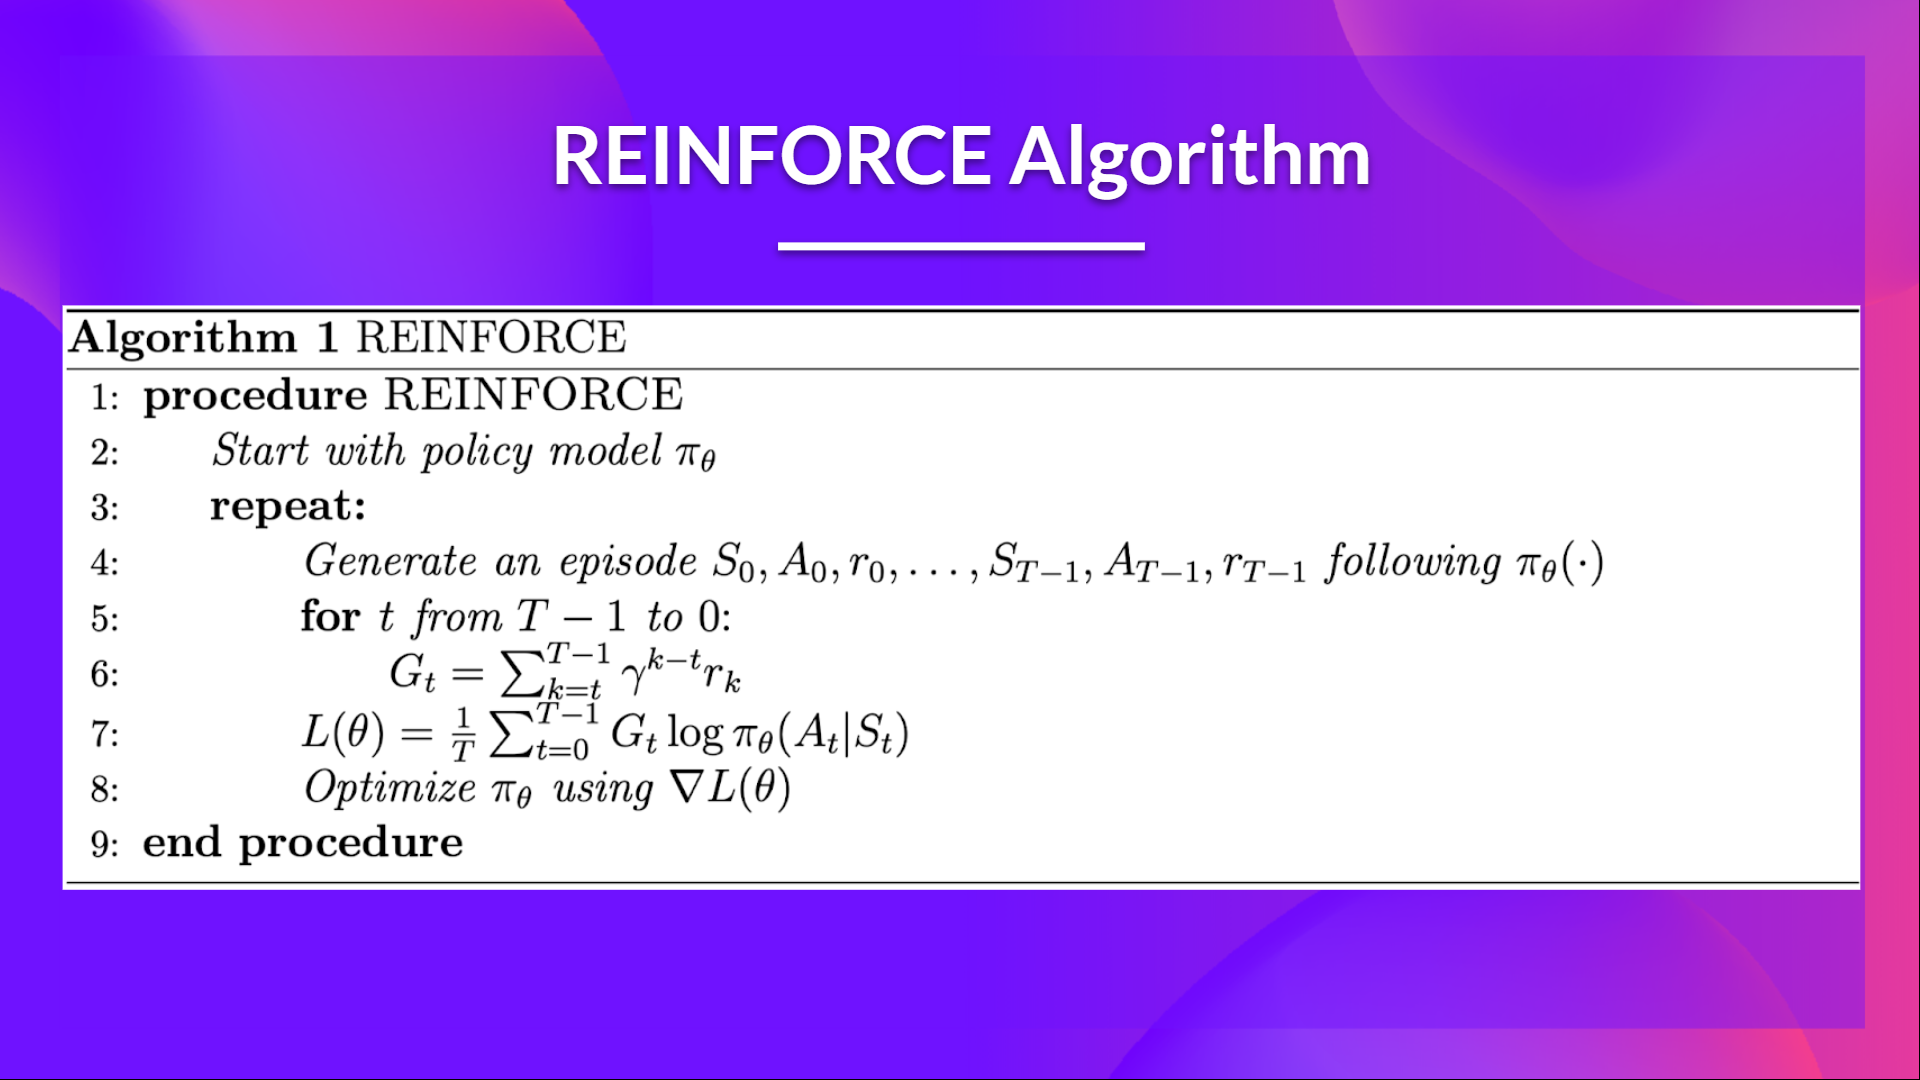

In [4]:
#The REINFORCE algorithm: More on the theory on their official website
def reinforce(policy,optimizer, n_training_episodes,max_t, gamma, print_every):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_ep in range(1, n_training_episodes + 1): #Line 3
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t): #Line 4
            action, log_prob = policy.act(state) #Given a state, return the prob dist of all possible actions
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action) #Get next state and reward from the chosen action
            rewards.append(reward)
            if done:
              break
        scores_deque.append(sum(rewards)) #the cumulative reward from the episode
        scores.append(sum(rewards))
        returns  = deque(maxlen=max_t) #Line 6
        n_steps = len(rewards)
        #Calculate the discounted returns at each timestep: Employ DP and calculate bottom up: Discounted return at timestep t : gamma[t] * return[t] + reward[t]
        #The queue "returns" hold the returns in chronological order(from t=0 -> t=n_steps)
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns) > 0 else 0)
            returns.appendleft(gamma * disc_return_t + rewards[t])

        #Adding a small unit to make numerical stable: Standardization
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        #Loss
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns): #Line 7
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        if i_ep % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_deque)))
    return scores


In [10]:
hyper = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 0.01,
    "env_id": env_id,
    "state_space": state_size,
    "action_space": action_size,
}

In [21]:
cartpole_policy = Policy(hyper['state_space'], hyper['action_space'], hyper['h_size']).to(device)
cartpole_optim = optim.Adam(cartpole_policy.parameters(), lr= hyper['lr'])


In [22]:
scores = reinforce(cartpole_policy, cartpole_optim, hyper['n_training_episodes'],hyper['max_t'], hyper['gamma'], 100)

Episode 100	Average Score: 34.05
Episode 200	Average Score: 205.93
Episode 300	Average Score: 467.43
Episode 400	Average Score: 306.03
Episode 500	Average Score: 454.12
Episode 600	Average Score: 428.13
Episode 700	Average Score: 496.44
Episode 800	Average Score: 500.00
Episode 900	Average Score: 500.00
Episode 1000	Average Score: 449.36


In [5]:
from os import fdatasync
#Evaluation
def evaluate(env, max_steps, n_eval_episodes, policy):
    ep_rewards= []
    for ep in range(n_eval_episodes):
        state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0
        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done ,info = env.step(action)
            total_rewards_ep += reward
            if done: break
            state = new_state
        ep_rewards.append(total_rewards_ep)
    mean_reward = np.mean(ep_rewards)
    std_reward = np.std(ep_rewards)
    return mean_reward, std_reward

In [24]:
evaluate(eval_env, hyper['max_t'], hyper['n_evaluation_episodes'], cartpole_policy)

(500.0, 0.0)

In [6]:
#Push to hub
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json
import imageio

import tempfile

import os

In [7]:
def record_video(env, policy, out_directory, fps=30):
  images = []
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action, _ = policy.act(state)
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [8]:
def push_to_hub(repo_id,
                model,
                hyperparameters,
                eval_env,
                video_fps=30
                ):
  #This is like in Unit 3

  _, repo_name = repo_id.split("/")
  api = HfApi()

  # Step 1: Create the repo
  repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
  )

  with tempfile.TemporaryDirectory() as tmpdirname:
    local_directory = Path(tmpdirname)

    # Step 2: Save the model
    torch.save(model, local_directory / "model.pt")

    # Step 3: Save the hyperparameters to JSON
    with open(local_directory / "hyperparameters.json", "w") as outfile:
      json.dump(hyperparameters, outfile)

    # Step 4: Evaluate the model and build JSON
    mean_reward, std_reward = evaluate(eval_env,
                                            hyperparameters["max_t"],
                                            hyperparameters["n_evaluation_episodes"],
                                            model)
    # Get datetime
    eval_datetime = datetime.datetime.now()
    eval_form_datetime = eval_datetime.isoformat()

    evaluate_data = {
          "env_id": hyperparameters["env_id"],
          "mean_reward": mean_reward,
          "n_evaluation_episodes": hyperparameters["n_evaluation_episodes"],
          "eval_datetime": eval_form_datetime,
    }

    # Write a JSON file
    with open(local_directory / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = hyperparameters["env_id"]

    metadata = {}
    metadata["tags"] = [
          env_name,
          "reinforce",
          "reinforcement-learning",
          "custom-implementation",
          "deep-rl-class"
      ]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
      )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **Reinforce** Agent playing **{env_id}**
  This is a trained model of a **Reinforce** agent playing **{env_id}** .
  To learn to use this model and train yours check Unit 4 of the Deep Reinforcement Learning Course: https://huggingface.co/deep-rl-course/unit4/introduction
  """

    readme_path = local_directory / "README.md"
    readme = ""
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
          readme = f.read()
    else:
      readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
      f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path =  local_directory / "replay.mp4"
    record_video(env, model, video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
          repo_id=repo_id,
          folder_path=local_directory,
          path_in_repo=".",
    )

    print(f"Your model is pushed to the Hub. You can view your model here: {repo_url}")

In [28]:
notebook_login()

In [30]:
repo_id = "lisagrace/Reinforce_v1"
push_to_hub(repo_id,
                cartpole_policy,
                hyper,
                eval_env,
                video_fps=30
                )

model.pt:   0%|          | 0.00/3.26k [00:00<?, ?B/s]

Your model is pushed to the Hub. You can view your model here: https://huggingface.co/lisagrace/Reinforce_v1


# Pixelcoper


In [9]:
#Env ref docs: https://pygame-learning-environment.readthedocs.io/en/latest/user/games/pixelcopter.html
env_id = "Pixelcopter-PLE-v0"
env = gym.make(env_id)
eval_env = gym.make(env_id)
s_size = env.observation_space.shape[0]
a_size = env.action_space.n
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


couldn't import doomish
Couldn't import doom
The State Space is:  7
Sample observation [ 2.3423126  -4.3148203   0.01454379 -0.8774069  -0.57364994  1.4049436
 -1.0003568 ]
The Action Space is:  2
Action Space Sample 1


In [10]:
#New policy
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size*2)
        self.fc3 = nn.Linear(h_size*2, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [11]:
hyper_h = {
    "h_size": 64,
    "n_training_episodes": 40000,
    "n_evaluation_episodes": 10,
    "max_t": 10000,
    "gamma": 0.99,
    "lr": 1e-4,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [12]:
#Training
torch.manual_seed(50)
pixelcopter_policy = Policy(hyper_h["state_space"], hyper_h["action_space"], hyper_h["h_size"]).to(device)
pixelcopter_optimizer = optim.Adam(pixelcopter_policy.parameters(), lr=hyper_h["lr"])

In [13]:
scores = reinforce(pixelcopter_policy,
                   pixelcopter_optimizer,
                   hyper_h["n_training_episodes"],
                   hyper_h["max_t"],
                   hyper_h["gamma"],
                   1000)

Episode 1000	Average Score: 3.48
Episode 2000	Average Score: 7.38
Episode 3000	Average Score: 10.30
Episode 4000	Average Score: 11.85
Episode 5000	Average Score: 11.07
Episode 6000	Average Score: 15.43
Episode 7000	Average Score: 15.06
Episode 8000	Average Score: 16.34
Episode 9000	Average Score: 19.12
Episode 10000	Average Score: 23.87
Episode 11000	Average Score: 23.23
Episode 12000	Average Score: 15.86
Episode 13000	Average Score: 23.19
Episode 14000	Average Score: 19.49
Episode 15000	Average Score: 21.82
Episode 16000	Average Score: 23.28
Episode 17000	Average Score: 27.55
Episode 18000	Average Score: 25.98
Episode 19000	Average Score: 24.12
Episode 20000	Average Score: 26.06
Episode 21000	Average Score: 30.01
Episode 22000	Average Score: 29.39
Episode 23000	Average Score: 30.82
Episode 24000	Average Score: 32.99
Episode 25000	Average Score: 18.87
Episode 26000	Average Score: 24.14
Episode 27000	Average Score: 34.86
Episode 28000	Average Score: 20.78
Episode 29000	Average Score: 31

In [14]:
repo_id = "lisagrace/reinforce-Pixelcopter"
push_to_hub(repo_id,
                pixelcopter_policy,
                hyper_h,
                eval_env,
                video_fps=30
                )

model.pt:   0%|          | 0.00/39.7k [00:00<?, ?B/s]

Your model is pushed to the Hub. You can view your model here: https://huggingface.co/lisagrace/reinforce-Pixelcopter


The model can be accessed at: [Link](https://huggingface.co/lisagrace/reinforce-Pixelcopter)
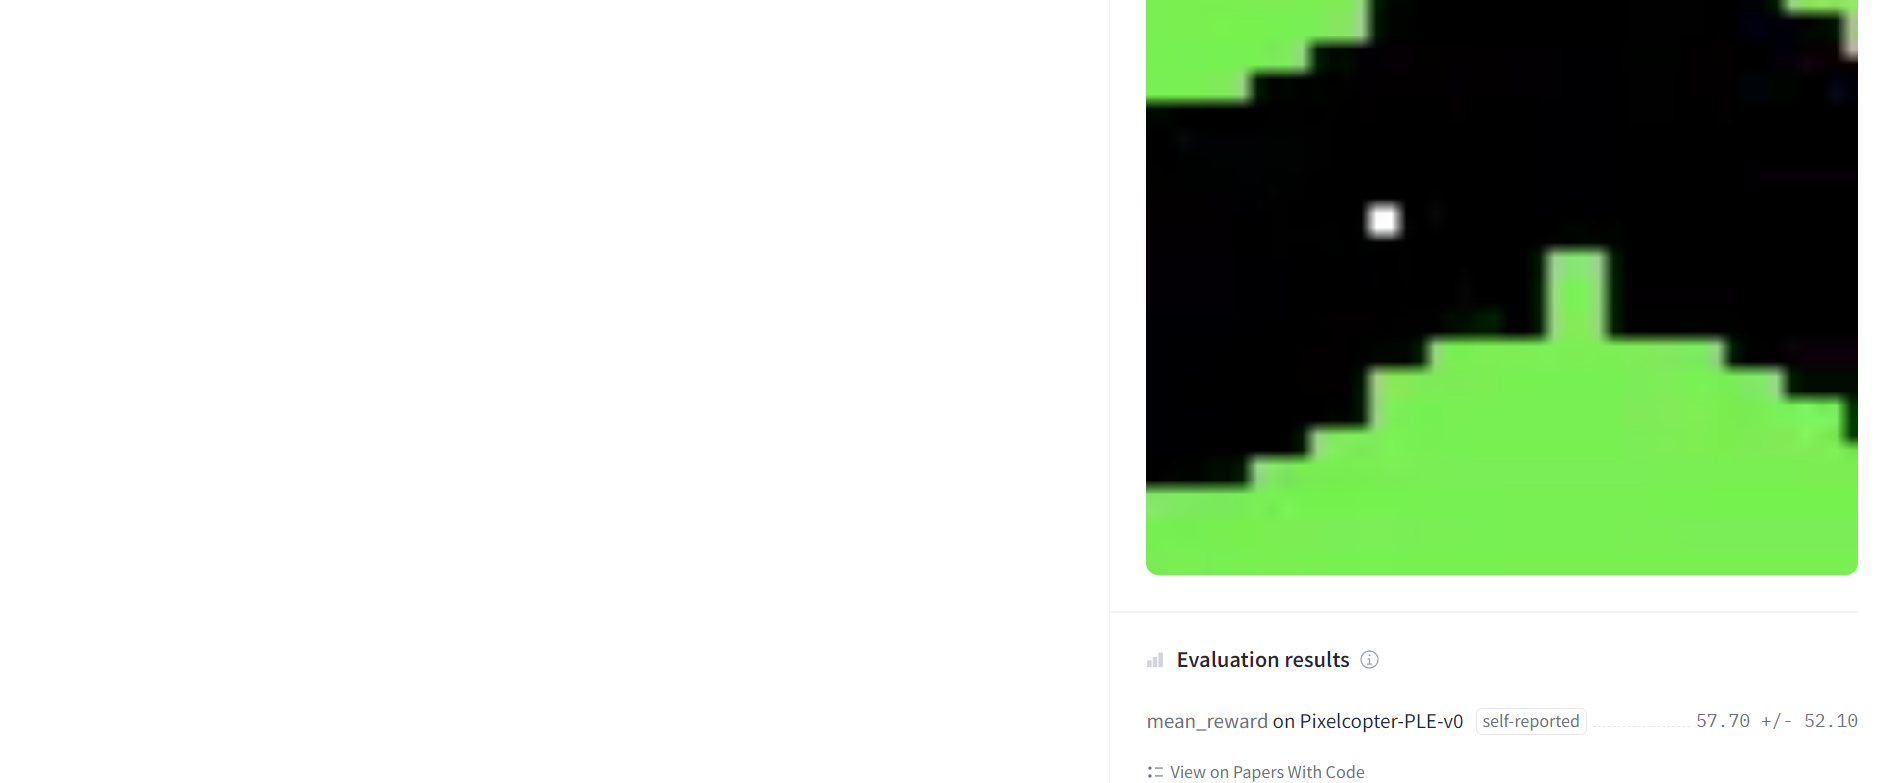